In [1]:
experiment_name = "lin_data_2_10_extrapolation_VAE"
exp_id = 1

In [2]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.linalg import svd, inv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from mpl_toolkits import mplot3d
import dill as pickle
import os
import pdb
import copy
import torch
import ai.causalcell
from ai.causalcell.training import set_seed, evaluate_epoch
from ai.causalcell.utils import configuration
os.chdir(os.path.join(os.path.dirname(ai.__file__), ".."))
print("Working in", os.getcwd())  

Working in /Users/paul/PycharmProjects/causal_cell_embedding


In [3]:
def set_inter_node(v):
    list(results['config']['dataset']['valid'].values())[0]['n_envs'] = 1
    list(results['config']['dataset']['valid'].values())[0]['inter_nodes'] = [v]

In [4]:
def set_inter_shift(v):
    list(results['config']['dataset']['valid'].values())[0]['inter_shifts'] = [v]

In [5]:
def get_best_valid_loss(i, name='recon_loss'):
    best_epoch = results['best_epoch']
    return np.mean([results['losses']['valid'][best_epoch][j][name].numpy() 
                    for j in range(len(results[i]['losses']['valid'][best_epoch]))])

In [6]:
def get_ground_truth_matrix():
    n_observations = results['data_graph'].n_observations
    n_hidden = results['data_graph'].n_hidden
    ground_truth_weight = np.zeros((n_observations, n_hidden))
    for edge in results['data_graph'].graph.in_edges.data(nbunch=results['data_graph'].get_observation_nodes(), 
                                                          data='weight'):
        ground_truth_weight[edge[1]-n_hidden, edge[0]] = edge[2]
    return ground_truth_weight


In [7]:
def get_model_matrix():
    return model.decoder.model[0].weight.detach().numpy()

In [8]:
def get_model_matrix_column_opp():
    model_mat = copy.deepcopy(model.decoder.model[0].weight.detach().numpy())
    model_mat[:, 0] *= -1
    return model_mat

In [9]:
result_dir = os.path.join(os.getcwd(), "results", experiment_name)

In [10]:
with open(os.path.join(result_dir,'results_' 
          + str(exp_id) + '.pkl'), 'rb') as f:
    results = pickle.load(f)

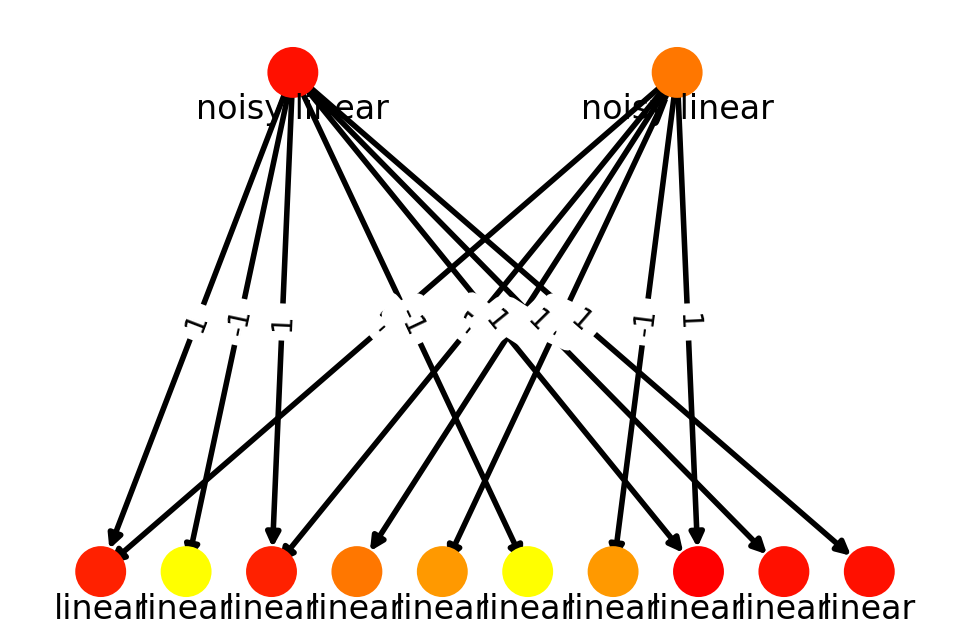

In [11]:
if results['data_graph'] is not None:
    plt.figure(dpi=200)
    results['data_graph'].draw(show_eq=True, show_weights=True, colorbar=False)
    plt.show()

In [12]:
results['config']

{'cuda': False,
 'seed': 3,
 'optimizer': {'Adam': {'lr': 0.0003}},
 'batch_size': 32,
 'n_epochs': 50,
 'generic': False,
 'exp_id': 1,
 'early_stopping': False,
 'patience_max': 4,
 'dataset': {'train': {'synthetic_iid_env_split': {'n_hidden': 2,
    'n_observations': 10,
    'n_examples_per_env': 10000,
    'n_envs': 1,
    'batch_size': 20,
    'train_val_test_prop': (1.0, 0.0, 0.0),
    'attach_proba': 0.5,
    'dag_generator': 'empty',
    'struct_eq_gen': 'noisy_lin_hidden_lin_obs',
    'inter_nodes': [0],
    'inter_shifts': [0.0]}},
  'valid': {'synthetic_iid_env_split': {'n_hidden': 2,
    'n_observations': 10,
    'n_examples_per_env': 1000,
    'n_envs': 1,
    'batch_size': 20,
    'train_val_test_prop': (0.0, 1.0, 0.0),
    'attach_proba': 0.5,
    'dag_generator': 'empty',
    'struct_eq_gen': 'noisy_lin_hidden_lin_obs',
    'inter_nodes': [0],
    'inter_shifts': [0.0]}}},
 'model': {'basic_VAE': {'enc_layers': [10, 5, 2],
   'dec_layers': [2, 10],
   'beta': 0.0001}},


## Evaluate OOD

In [13]:
model = configuration.setup_model(results['config'])
model.load_state_dict(torch.load(os.path.join(result_dir, "best_model_" + str(exp_id) + ".pth.tar")))

<All keys matched successfully>

In [14]:
model

VariationalAutoEncoder(
  (encoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=10, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (mu): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=5, out_features=2, bias=True)
    )
  )
  (logvar): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=5, out_features=2, bias=True)
    )
  )
  (decoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
    )
  )
  (criterion): MSELoss()
)

In [15]:
def evaluate_along_var(i):
    x = []
    y = []
    set_inter_node(i)
    for j in np.arange(-20, 20, 0.5):
        set_inter_shift(j)
        set_seed(results['seed'])
        # dataloader
        valid_loader = configuration.setup_dataloader(results['config'], 'valid')
        valid_loss, valid_losses = evaluate_epoch(model=model, device='cpu', data_loader=valid_loader, epoch=0)
        x.append(j)
        y.append(np.mean([valid_losses[j]['recon_loss'].numpy() for j in range(len(valid_losses))]))
    return x, y

In [16]:
x0, y0 = evaluate_along_var(0)
x1, y1 = evaluate_along_var(1)

pytorch/random seed: 3


RDKit WARNING: [12:17:58] Enabling RDKit 2019.09.3 jupyter extensions


global graph created with parameters (2, 10, 0.5, 'empty', 'noisy_lin_hidden_lin_obs')
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 2.6551
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 2.5329
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 2.4031
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 2.2769
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 2.1541
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 2.0348
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environme

valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 1.0498
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 1.2016
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 1.3728
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 1.5649
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 1.7787
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 2.0153
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 2.2754
pytorch/random seed: 3
global graph already insta

epoch 0 Mean valid loss: 12.3266
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 13.9098
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 15.6148
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 17.4416
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 19.3901
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 21.4604
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of environments 1
epoch 0 Mean valid loss: 23.6525
pytorch/random seed: 3
global graph already instantiated
valid split of size 1000 with number of 

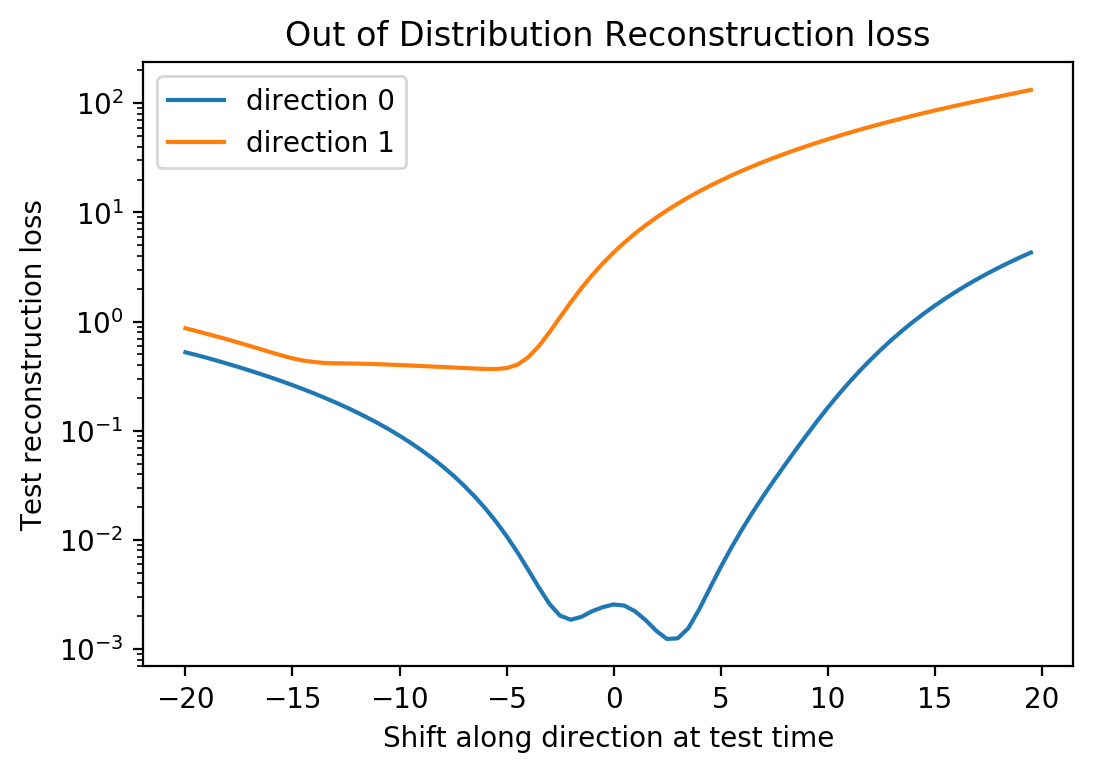

In [17]:
plt.figure(dpi=200)
plt.plot(x0, y0, label="direction 0")
plt.title("Out of Distribution Reconstruction loss")
plt.xlabel('Shift along direction at test time')
plt.ylabel('Test reconstruction loss')
plt.legend()
# plt.yscale("log")
# plt.show()
plt.plot(x1, y1, label="direction 1")
# plt.title("Out of Distribution Reconstruction loss")
# plt.xlabel('Shift along direction at test time')
# plt.ylabel('Valid reconstruction loss')
plt.legend()
plt.yscale("log")
plt.show()

In [192]:
ground_truth_matrix = get_ground_truth_matrix()

In [193]:
model_matrix = get_model_matrix()

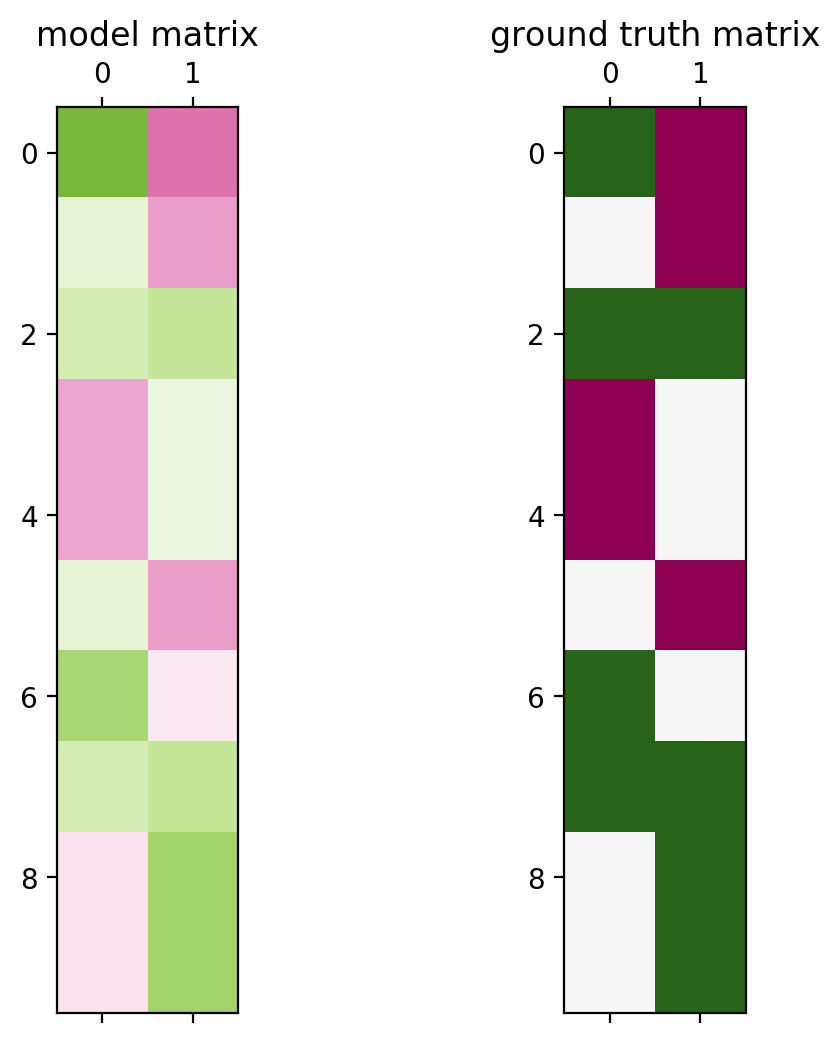

In [194]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6), dpi=200)
ax1.matshow(model_matrix, cmap="PiYG", vmin=-1.,vmax=1.)
ax1.set_title("model matrix")
ax2.matshow(ground_truth_matrix, cmap="PiYG", vmin=-1.,vmax=1.)
ax2.set_title("ground truth matrix")
plt.show()

Difference between ground truth and learnt matrices

In [195]:
def cosine_dist(A, B):
    """
    Compute the sum of cosine distances between the rows of A and B
    """
    dist = 0
    for i in range(len(get_ground_truth_matrix())):
        dist += cosine(A[i], B[i])
    return dist

In [196]:
def cosine_dist_ith_components(A, B, i):
    return cosine(A[i], B[i])

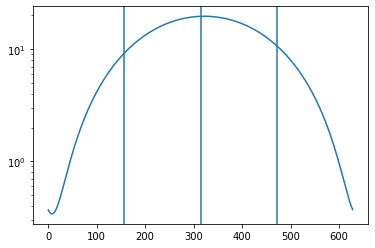

In [197]:
dist_to_ground_truth = []
for theta in np.arange(0, 2*np.pi, 0.01):
    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rotated_weights = get_model_matrix()[:, :2].dot(rot)
    dist_to_ground_truth.append(cosine_dist(rotated_weights, get_ground_truth_matrix()))

plt.axvline(x=100*np.pi, ymin=0, ymax=20)
plt.axvline(x=100*1/2*np.pi, ymin=0, ymax=20)
plt.axvline(x=100*3/2*np.pi, ymin=0, ymax=20)
plt.plot(dist_to_ground_truth)
plt.yscale("log")
plt.show()

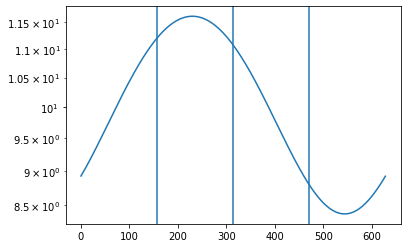

In [198]:
dist_to_ground_truth = []
for theta in np.arange(0, 2*np.pi, 0.01):
    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rotated_weights = get_model_matrix_column_opp()[:, :2].dot(rot)
    dist_to_ground_truth.append(cosine_dist(rotated_weights, get_ground_truth_matrix()))

plt.axvline(x=100*np.pi, ymin=0, ymax=20)
plt.axvline(x=100*1/2*np.pi, ymin=0, ymax=20)
plt.axvline(x=100*3/2*np.pi, ymin=0, ymax=20)
plt.plot(dist_to_ground_truth)
plt.yscale("log")
plt.show()

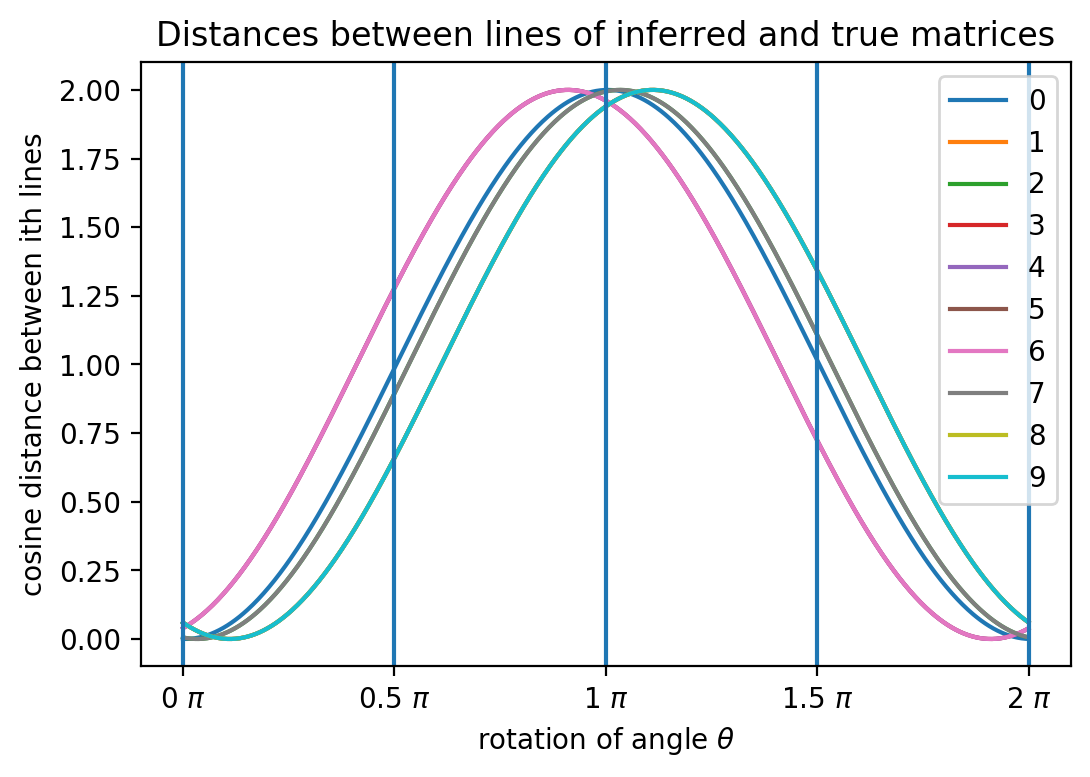

In [199]:
f,ax=plt.subplots(dpi=200)
for j in range(10):
    dist_to_ground_truth = []
    for theta in np.arange(0, 2*np.pi, 0.01):
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_weights = get_model_matrix()[:, :2].dot(rot)
        dist_to_ground_truth.append(cosine_dist_ith_components(rotated_weights, get_ground_truth_matrix(),j))
    ax.plot([0.01/(np.pi)*i for i in range(len(dist_to_ground_truth))], dist_to_ground_truth, label=str(j))
ax.legend()
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
ax.axvline(x=0, ymin=0, ymax=20)
ax.axvline(x=0.5, ymin=0, ymax=20)
ax.axvline(x=1, ymin=0, ymax=20)
ax.axvline(x=3/2, ymin=0, ymax=20)
ax.axvline(x=2, ymin=0, ymax=20)
ax.set_xlabel(r'rotation of angle $\theta$')
ax.set_ylabel('cosine distance between ith lines')
ax.set_title('Distances between lines of inferred and true matrices')
# plt.yscale("log")
plt.show()

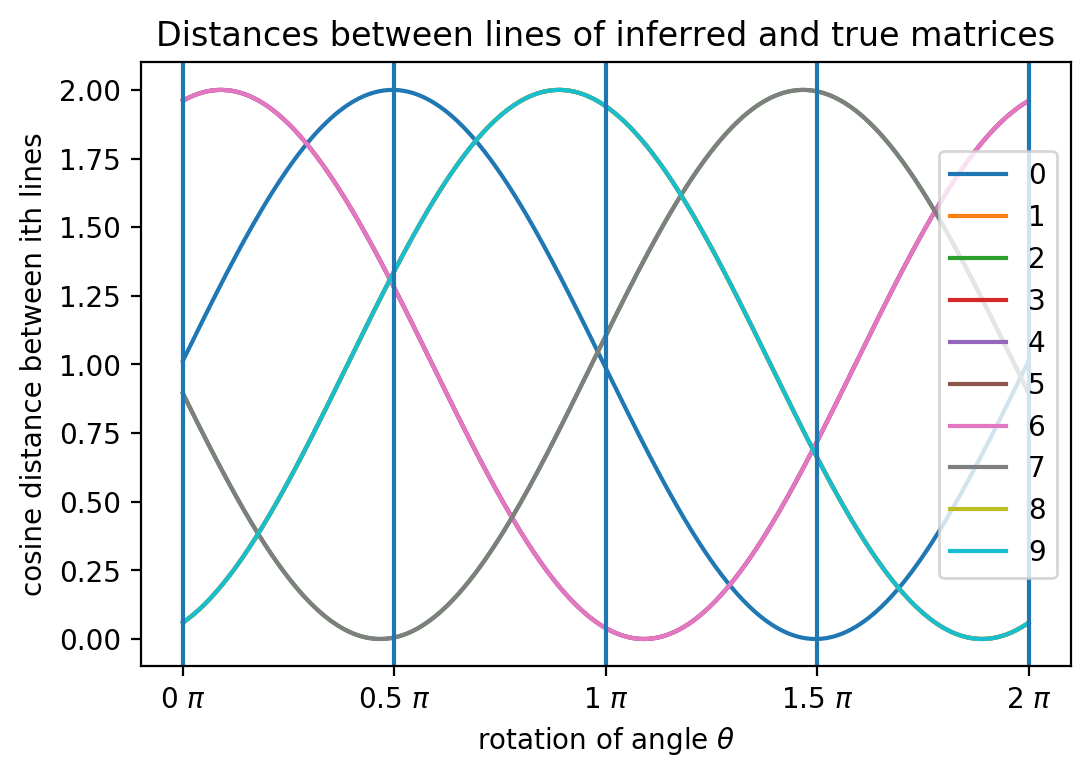

In [200]:
f,ax=plt.subplots(dpi=200)
for j in range(10):
    dist_to_ground_truth = []
    for theta in np.arange(0, 2*np.pi, 0.01):
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_weights = get_model_matrix_column_opp()[:, :2].dot(rot)
        dist_to_ground_truth.append(cosine_dist_ith_components(rotated_weights, get_ground_truth_matrix(), j))
    ax.plot([0.01/(np.pi)*i for i in range(len(dist_to_ground_truth))], dist_to_ground_truth, label=str(j))
ax.legend()
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
ax.axvline(x=0, ymin=0, ymax=20)
ax.axvline(x=0.5, ymin=0, ymax=20)
ax.axvline(x=1, ymin=0, ymax=20)
ax.axvline(x=3/2, ymin=0, ymax=20)
ax.axvline(x=2, ymin=0, ymax=20)
# plt.yscale("log")
ax.set_title('Distances between lines of inferred and true matrices')
ax.set_xlabel(r'rotation of angle $\theta$')
ax.set_ylabel('cosine distance between ith lines')
plt.show()